In [1]:
import sys
import time
import warnings

#!{sys.executable} -m pip install unidecode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pre-processing
import re
import unidecode
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup

import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/askani.mohankrishna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/askani.mohankrishna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import pandas as pd
train_data = pd.read_csv('X_train_twitter.csv')
train_data.head()

,Unnamed: 0,Id,title,time,keywords,data source,country,source URL,body,language
0,2642,1.400000e+18,NaN,2021-06-02 07:46:57+00:00,NaN,Twitter,Jamaica,NaN,had a dream a flood came and covered everythin...,English
1,3540,1.030000e+18,NaN,2021-04-27 06:02:44+00:00,"['species', 'fruit', 'flowers', 'environments'...",Twitter,NaN,https://twitter.com/Pearsonw_matt/status/13868...,I find she-oaks a genuinely fascinating #speci...,English
2,4173,1.400000e+18,NaN,2021-06-01 02:29:59+00:00,['marketpulse'],Twitter,Australia,https://twitter.com/AuctionsPlus/status/139961...,"Cattle Breed Breakdowns - Hereford ""The larges...",English
3,4143,1.400000e+18,NaN,2021-06-02 21:22:36+00:00,[],Twitter,Australia,https://twitter.com/corruptagenda/status/14002...,@davidbewart The National party are only there...,English
4,3748,1.170000e+18,NaN,2021-04-20 21:08:22+00:00,"['insuranceclaims', 'firedamage', 'flooddamage...",Twitter,NaN,https://twitter.com/SDamages/status/1384531896...,Damages to your Home! We are here working for ...,English


In [3]:
train_labels = pd.read_csv('y_train_twitter.csv')
train_labels.head()

,category
0,none
1,none
2,drought
3,drought
4,none


In [4]:
train_labels['category'].value_counts()

none       57
drought    56
Name: category, dtype: int64

In [5]:
train_data = train_data[['body']]
train_data.head()

,body
0,had a dream a flood came and covered everythin...
1,I find she-oaks a genuinely fascinating #speci...
2,"Cattle Breed Breakdowns - Hereford ""The larges..."
3,@davidbewart The National party are only there...
4,Damages to your Home! We are here working for ...


In [6]:
train_labels['category'].value_counts()

none       57
drought    56
Name: category, dtype: int64

In [7]:
import re
from tqdm import tqdm
def preprocess(article):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the article
    text = article.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
preprocessed = [preprocess(article) for article in tqdm(train_data['body'])]

100%|██████████| 113/113 [00:00<00:00, 14890.24it/s]


In [8]:
preprocessed[0]

'had dream flood came and covered everything except this tiny patch of land where was sitting heavily pregnant and chain smoking just watching the water what on earth is going on in my subconsciousness'

In [9]:
from collections import Counter
counts = dict(Counter(word for sentence in preprocessed for word in sentence.split()))
{k: counts[k] for k in list(counts)[:10]}

{'had': 5,
 'dream': 1,
 'flood': 16,
 'came': 3,
 'and': 97,
 'covered': 1,
 'everything': 4,
 'except': 1,
 'this': 18,
 'tiny': 1}

In [10]:
test_data = pd.read_csv('X_test_twitter.csv')

data_test = test_data['body']
data_test = [preprocess(article) for article in tqdm(data_test)]

test_labels = pd.read_csv('y_test_twitter.csv')


100%|██████████| 29/29 [00:00<00:00, 25089.69it/s]


In [14]:
embed_size = 300 # how big is each word vector
max_features = 800 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 500 # max number of words in a content to use

In [15]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(preprocessed)
train_X = tokenizer.texts_to_sequences(preprocessed)
test_X = tokenizer.texts_to_sequences(data_test)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

le = LabelEncoder()
train_y = le.fit_transform(train_labels['category'].values)
test_y = le.transform(test_labels['category'].values)
len(le.classes_)

2

In [16]:
len(tokenizer.word_index)

1427

In [17]:
import pickle
with open("tokenizer_drought_v1.pkl", 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)
with open("label_encoder_drought_v1.pkl", 'wb') as file:
    pickle.dump(le, file, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
EMBEDDING_FILE = 'glove.840B.300d.txt'
debug = 0
def load_glove(word_index):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    del embeddings_index['PN']
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

if debug:
    embedding_matrix = np.random.randn(max_features,embed_size)
else:
    embedding_matrix = load_glove(tokenizer.word_index)
np.shape(embedding_matrix)

/Users/askani.mohankrishna/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(800, 300)

In [19]:
import numpy as np
np.save('embedding_matrix_drought_v1.npy' , embedding_matrix)

In [20]:
train_X1 = train_X[:2]

#Paste num in self.extra_features below 
train_X1.shape[1] - maxlen

0

In [21]:
class BiLSTM(nn.Module): 
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size_1 = 64
        self.hidden_size_2 = 64
        self.extra_features = 0
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size_1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size_1*4 + self.extra_features, self.hidden_size_2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(self.hidden_size_2, n_classes)

    def forward(self, x):
        input = x[:,:maxlen]
        of = x[:,maxlen:]
        
        h_embedding = self.embedding(input)
        
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool, of), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [34]:
n_epochs = 6
batch_size = 10


model = BiLSTM()

loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long)#.cuda()
y_train = torch.tensor(train_y, dtype=torch.long)#.cuda()

x_cv = torch.tensor(test_X, dtype=torch.long)#.cuda()
y_cv = torch.tensor(test_y, dtype=torch.long)#.cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))


<ipython-input-34-7e24d02d9957>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=6.6554 	 val_loss=6.5658  	 val_acc=0.6897  	 time=3.46s
Epoch 2/6 	 loss=6.2594 	 val_loss=6.3143  	 val_acc=0.7586  	 time=3.37s
Epoch 3/6 	 loss=5.7522 	 val_loss=5.6809  	 val_acc=0.8276  	 time=3.29s
Epoch 4/6 	 loss=4.6343 	 val_loss=4.6962  	 val_acc=0.8621  	 time=3.35s
Epoch 5/6 	 loss=3.2974 	 val_loss=4.1177  	 val_acc=0.8621  	 time=3.31s
Epoch 6/6 	 loss=1.8988 	 val_loss=3.8427  	 val_acc=0.7931  	 time=3.60s


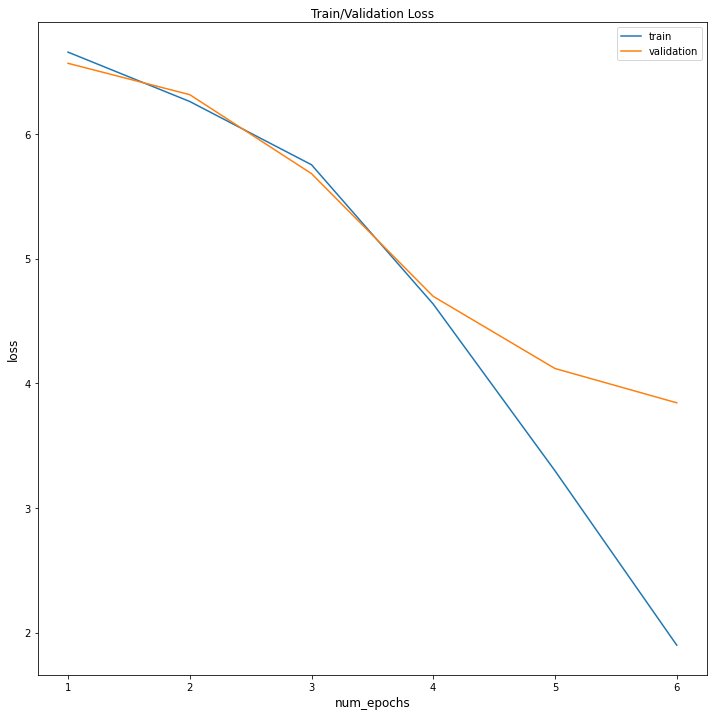

In [35]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
plot_graph(n_epochs)

In [36]:
pred = le.inverse_transform(val_preds.argmax(axis=1))
test = le.inverse_transform(test_y)
from sklearn.metrics import classification_report
print(classification_report(test,pred,labels=train_labels['category'].unique()))

              precision    recall  f1-score   support

        none       0.79      0.79      0.79        14
     drought       0.80      0.80      0.80        15

    accuracy                           0.79        29
   macro avg       0.79      0.79      0.79        29
weighted avg       0.79      0.79      0.79        29



In [37]:
filename = 'model_twitter_drought_v1.pt'
torch.save(model.state_dict(), filename)